# Problem Framing

The goal of this notebook is to develop and test different strategies of data imputation. We're gonna be using both supervised and unsupervised methods, and both traditional Machine Learning algorithms and state-of-the-art deep learning solutions.
The discriminative ML methods we're gonna be using are:
- KNN Imputer
- Iterative Imputer

And the DL methods include:
- Iterative Multi-layer Perceptron (MLP) Imputer
- Auto-encoder Imputer
- Generative Adversarial Network (GAN) Imputer

# Selecting a performance measure

In this notebook, we're working on the diabetes dataset, which includes numerical attributes only. A good performance measure would be the `root mean squared error` (RMSE) averaged over all the predicted columns.


# Requirements

In [16]:
import os
import random
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim

# Download the data

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mathchi/diabetes-data-set")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1


# Set Args

In [18]:
theta = 7
num_epochs = 500
dropout_ratio = 0.5

data_path = '/root/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1/diabetes.csv'
mechanism = 'mcar'
method = 'uniform'

test_size = 0.3
use_cuda = True
batch_size  = 8 # not in the paper

# Prepare Data

In [19]:
df = pd.read_csv(data_path)
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [20]:
data = pd.read_csv(data_path).values

rows, cols = data.shape
shuffled_index = np.random.permutation(rows)
train_index = shuffled_index[:int(rows*(1-test_size))]
test_index = shuffled_index[int(rows*(1-test_size)):]

train_data = data[train_index, :]
test_data = data[test_index, :]

# standardized between 0 and 1
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [21]:
def missing_method(raw_data, mechanism='mcar', method='uniform', missing_threshold=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    data = raw_data.copy()
    rows, cols = data.shape
    t = missing_threshold

    if mechanism == 'mcar':
        v = np.random.uniform(size=(rows, cols))
        if method == 'uniform':
            mask = v <= t
        elif method == 'random':
            c = np.zeros(cols, dtype=bool)
            c[np.random.choice(cols, cols // 2, replace=False)] = True
            mask = (v <= t) & c[np.newaxis, :]
        else:
            raise ValueError(f"Unknown method: {method}")
    elif mechanism == 'mnar':
        sample_cols = np.random.choice(cols, 2, replace=False)
        m1, m2 = np.median(data[:, sample_cols], axis=0)
        v = np.random.uniform(size=(rows, cols))
        m = (data[:, sample_cols[0]] <= m1) & (data[:, sample_cols[1]] >= m2)
        mask = v <= t
        if method == 'uniform':
            mask &= m[:, np.newaxis]
        elif method == 'random':
            c = np.zeros(cols, dtype=bool)
            c[np.random.choice(cols, cols // 2, replace=False)] = True
            mask &= m[:, np.newaxis] & c[np.newaxis, :]
        else:
            raise ValueError(f"Unknown method: {method}")
    else:
        raise ValueError(f"Unknown mechanism: {mechanism}")

    data[mask] = 0
    return data, mask

In [22]:
missed_data, mask = missing_method(test_data, mechanism=mechanism, method=method)

missed_data = torch.from_numpy(missed_data).float()
train_data = torch.from_numpy(train_data).float()

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

In [23]:
print("Original Data:\n", data)
print("Modified Data (with missing values):\n", missed_data)
print("Mask of Missing Values:\n", mask)

Original Data:
 [[  6.    148.     72.    ...   0.627  50.      1.   ]
 [  1.     85.     66.    ...   0.351  31.      0.   ]
 [  8.    183.     64.    ...   0.672  32.      1.   ]
 ...
 [  5.    121.     72.    ...   0.245  30.      0.   ]
 [  1.    126.     60.    ...   0.349  47.      1.   ]
 [  1.     93.     70.    ...   0.315  23.      0.   ]]
Modified Data (with missing values):
 tensor([[0.1765, 0.0000, 0.6909,  ..., 0.0573, 0.2667, 0.0000],
        [0.0588, 0.6231, 0.6727,  ..., 0.0098, 0.1500, 0.0000],
        [0.0000, 0.5678, 0.0000,  ..., 0.3536, 0.0000, 0.0000],
        ...,
        [0.0000, 0.4724, 0.0000,  ..., 0.0791, 0.0667, 0.0000],
        [0.5294, 0.6231, 0.0000,  ..., 0.0000, 0.2167, 0.0000],
        [0.7059, 0.0000, 0.6727,  ..., 0.1333, 0.4500, 0.0000]])
Mask of Missing Values:
 [[False  True False ... False False  True]
 [False False False ... False False False]
 [False False  True ... False  True False]
 ...
 [False False False ... False False False]
 [False Fa

# Define Model

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
from itertools import product
from statistics import stdev
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
import torch.optim as optim

# Define ranges for hyperparameters
theta_values = [5] #, 7, 10
num_epochs_values = [100] #, 300, 500
dropout_ratios = [0.7] #0.3, 0.5,

# Results tracking
best_rmse = float('inf')
best_config = {}

# Grid search over hyperparameters
for theta, num_epochs, dropout_ratio in product(theta_values, num_epochs_values, dropout_ratios):
    print(f"Training with theta={theta}, num_epochs={num_epochs}, dropout_ratio={dropout_ratio}")

    # Update the model definition with new dropout_ratio
    class Autoencoder(nn.Module):
        def __init__(self, dim):
            super(Autoencoder, self).__init__()
            self.dim = dim
            self.drop_out = nn.Dropout(p=dropout_ratio)
            self.encoder = nn.Sequential(
                nn.Linear(dim + theta * 0, dim + theta * 1),
                nn.Tanh(),
                nn.Linear(dim + theta * 1, dim + theta * 2),
                nn.Tanh(),
                nn.Linear(dim + theta * 2, dim + theta * 3),
            )
            self.decoder = nn.Sequential(
                nn.Linear(dim + theta * 3, dim + theta * 2),
                nn.Tanh(),
                nn.Linear(dim + theta * 2, dim + theta * 1),
                nn.Tanh(),
                nn.Linear(dim + theta * 1, dim + theta * 0),
            )

        def forward(self, x):
            x = x.view(-1, self.dim)
            x_missed = self.drop_out(x)
            z = self.encoder(x_missed)
            out = self.decoder(z)
            return out.view(-1, self.dim)

    # Initialize model, optimizer, and scheduler
    model = Autoencoder(dim=cols).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99, nesterov=True)
    loss = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR every 50 epochs

    # Training loop
    early_stop = False
    cost_list = []
    for epoch in range(num_epochs):
        total_batch = len(train_data) // batch_size
        for i, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)

            # Forward pass and loss computation
            reconst_data = model(batch_data)
            cost = loss(reconst_data, batch_data)

            # Backpropagation
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        # Update learning rate scheduler
        scheduler.step()

        # Early stopping based on MSE threshold
        if cost.item() < 1e-6:
            early_stop = True
            break

        cost_list.append(cost.item())

    if early_stop:
        print(f"Early stopping at epoch {epoch+1}")

    # Evaluation
    model.eval()
    filled_data = model(missed_data.to(device))
    filled_data = filled_data.cpu().detach().numpy()

    rmse_values = []
    for i in range(cols):
        if mask[:, i].sum() > 0:
            y_actual = test_data[:, i][mask[:, i]]
            y_predicted = filled_data[:, i][mask[:, i]]
            rmse = sqrt(mean_squared_error(y_actual, y_predicted))
            rmse_values.append(rmse)

    rmse_sum = sum(rmse_values)
    rmse_std = stdev(rmse_values)

    print(f"RMSE_SUM for config theta={theta}, num_epochs={num_epochs}, dropout_ratio={dropout_ratio}: {rmse_sum}")
    print(f"RMSE_STD for config theta={theta}, num_epochs={num_epochs}, dropout_ratio={dropout_ratio}: {rmse_std}")

    # Update best configuration
    if rmse_sum < best_rmse:
        best_rmse = rmse_sum
        best_config = {
            "theta": theta,
            "num_epochs": num_epochs,
            "dropout_ratio": dropout_ratio,
            "rmse_std": rmse_std
        }

print("Best configuration:", best_config)
print("Best RMSE_SUM:", best_rmse)
print("Standard Deviation for Best RMSE_SUM:", best_config["rmse_std"])

Training with theta=5, num_epochs=100, dropout_ratio=0.7
RMSE_SUM for config theta=5, num_epochs=100, dropout_ratio=0.7: 1.8290643640868147
RMSE_STD for config theta=5, num_epochs=100, dropout_ratio=0.7: 0.14723617772924397
Best configuration: {'theta': 5, 'num_epochs': 100, 'dropout_ratio': 0.7, 'rmse_std': 0.14723617772924397}
Best RMSE_SUM: 1.8290643640868147
Standard Deviation for Best RMSE_SUM: 0.14723617772924397


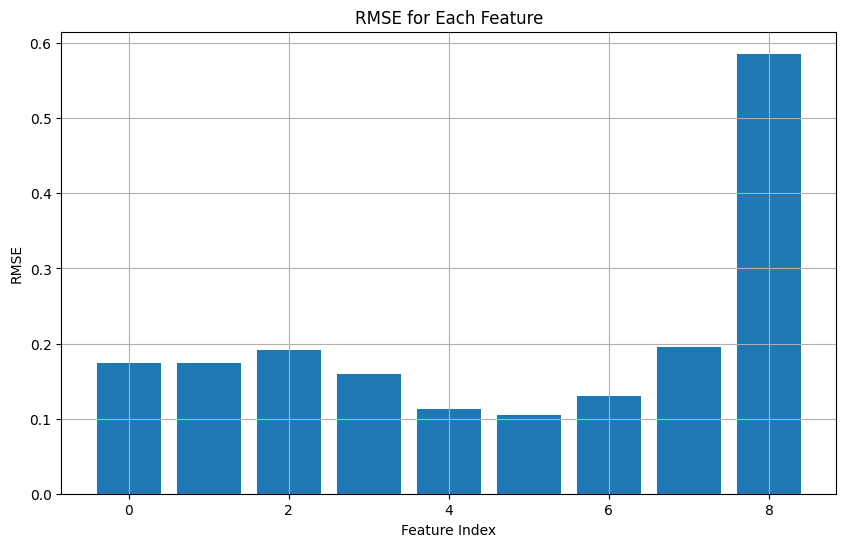

In [28]:
from sklearn.metrics import mean_squared_error

rmse_per_feature = []

# Compute RMSE for each feature
for i in range(test_data.shape[1]):
    if mask[:, i].sum() > 0:
        y_actual = test_data[:, i][mask[:, i]]
        y_predicted = filled_data[:, i][mask[:, i]]
        rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
        rmse_per_feature.append(rmse)
    else:
        rmse_per_feature.append(None)  # No missing values for this feature

# Plot RMSE per feature
plt.figure(figsize=(10, 6))
plt.bar(range(len(rmse_per_feature)), [x if x is not None else 0 for x in rmse_per_feature])
plt.xlabel("Feature Index")
plt.ylabel("RMSE")
plt.title("RMSE for Each Feature")
plt.grid()
plt.show()
